In [1]:
using Plots
using LaTeXStrings
using FilePathsBase
using Dates
using Statistics

In [2]:
include("src/constants.jl")
include("src/main.jl")
include("src/solver_code.jl")
include("src/piecewise_polytrope_eos_cgs.jl")
using .MainModule
using .SolverCode
using .PiecePoly
# Typical scale
println("length scale: ", unit_l, " cm")
println("mass scale: ", unit_g, " g")
println("energy density scale: ", eps_ref, " g/cm^3")
println("energy density scale: ", eps_ref*gcm3_to_MeVfm3, " MeV/fm^3")

length scale: 1.0 cm
mass scale: 1.3465949566647152e28 g
energy density scale: 1.2102591909632933e49 g/cm^3
energy density scale: 6.789056165277286e36 MeV/fm^3


In [3]:
println("Original parameters: ", PiecePoly.fixed_ρ_bounds)
PiecePoly.fixed_ρ_bounds = [4.28800e+14, 8.55829e+14]
println("Changed parameters: ", PiecePoly.fixed_ρ_bounds)

Original parameters: [5.0118723362727144e14, 1.0e15]
Changed parameters: [4.288e14, 8.55829e14]


In [4]:
K1 = 3.50290e-5
ρ_upper_bound = 4.28800E+14 
γ = 2.64258
log10P1 = log10(K1*(ρ_upper_bound^γ))
log10P1 = 34.21136192879 
# rho_lim_all[4] - 1.02148E+14 が小さくなるように手で調整した
# 34.21136192879 - log10(K1*(ρ_upper_bound^γ)) = 3.036166486936054e-5

rho_lim_all, a_all, K_all, Gamma_all = PiecePoly.get_all_params(log10P1, [2.64258, 3.5, 1.45303])
ε_temp, p_temp = PiecePoly.make_polyEos(rho_lim_all, a_all, K_all, Gamma_all)
ε, p = MainModule.make_eos_monotonic(ε_temp, p_temp)
println(log10P1, ", ", Gamma_all)
# rho_lim_all[4] = 1.02148e+14
println(rho_lim_all)
println(rho_lim_all[4] - 1.02148E+14)

34.21136192879, [1.58425, 1.28733, 0.62223, 1.35692, 2.64258, 3.5, 1.45303]
[2.44034e7, 3.78358e11, 2.6278e12, 1.0214800000032905e14, 4.288e14, 8.55829e14, Inf]
329.046875


In [5]:
# ファイルパスを指定
file_path = "data/eos_HQC18_gv100H160.txt"
P = []
e = []
cs2 = [] 
# ファイルを行単位で読み込む
lines = readlines(file_path)
println(lines[1])
for line in lines[2:end]
    # 行をスペースで分割して各値を数値に変換
    values = parse.(Float64, split(line))
    push!(P, values[2]) 
    push!(e, values[4]) 
    push!(cs2, values[5].^2) 
end
mono_e, mono_P = MainModule.make_eos_monotonic(e, P)

file_path2 = "data/eos_HQC18_gv080H150.txt"
P2 = []
e2 = []
lines = readlines(file_path2)
for line in lines[2:end]
    values = parse.(Float64, split(line))
    push!(P2, values[2]) 
    push!(e2, values[4])
end
mono_e2, mono_P2 = MainModule.make_eos_monotonic(e2, P2)

file_path3 = "data/eos_HQC18_gv050H140.txt"
P3 = []
e3 = []
lines = readlines(file_path3)
for line in lines[2:end]
    values = parse.(Float64, split(line))
    push!(P3, values[2]) 
    push!(e3, values[4])
end
mono_e3, mono_P3 = MainModule.make_eos_monotonic(e3, P3)
println(length(mono_e3))

 muB (MeV)    P (MeV/fm^3)           nB/n0    e (MeV/fm^3)              cs
393


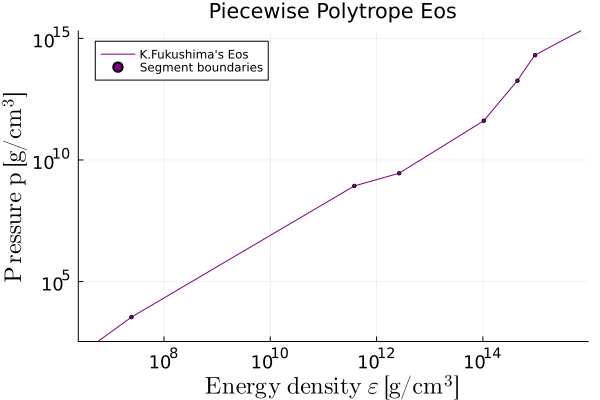

In [35]:
eps_bounds = PiecePoly.eps_rho_def.(rho_lim_all, K_all, Gamma_all, a_all)
p_bounds = PiecePoly.p_rho_def.(rho_lim_all, K_all, Gamma_all)
plot(ε, p;
    label="K.Fukushima's Eos",
    xlabel=L"\mathrm{Energy\ density\ \varepsilon\ [g/cm^3]}",xlabelfontsize=16,
    ylabel=L"\mathrm{Pressure\ p\ [g/cm^3]}", ylabelfontsize=16,
    title="Piecewise Polytrope Eos",
    legend=:topleft,
    xscale=:log10,  # x軸を対数スケールに変更
    yscale=:log10,  # y軸を対数スケールに変更)
    xtickfontsize=12,
    ytickfontsize=12,
    color=:purple,
    xlims=(eps_bounds[1]*0.1, eps_bounds[end-1]*10), ylims=(p_bounds[1]*0.1, p_bounds[end-1]*10),
)
scatter!(eps_bounds, p_bounds;
    label="Segment boundaries",
    color=:purple,
    markersize=2
)
# savefig("KF_EoS.png")

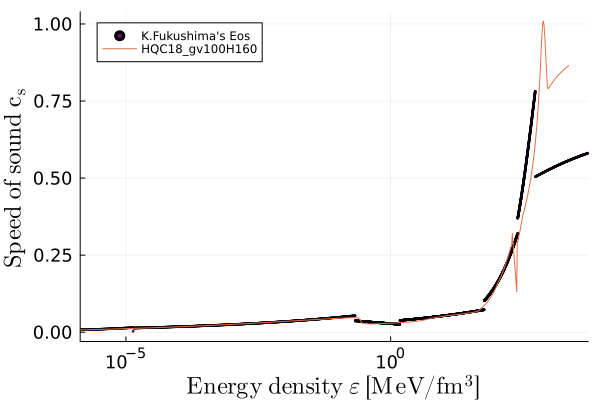

In [7]:
eps_bounds = PiecePoly.eps_rho_def.(rho_lim_all, K_all, Gamma_all, a_all).*gcm3_to_MeVfm3
p_bounds = PiecePoly.p_rho_def.(rho_lim_all, K_all, Gamma_all).*gcm3_to_MeVfm3
scatter(ε[2:end].*gcm3_to_MeVfm3, [sqrt((p[i]-p[i-1])/(ε[i]-ε[i-1])) for i in 2:length(p)];
    label="K.Fukushima's Eos",
    xlabel=L"\mathrm{Energy\ density\ \varepsilon\ [MeV/fm^3]}",xlabelfontsize=16,
    ylabel=L"\mathrm{Speed\ of\ sound\ c_s}", ylabelfontsize=16,
    legend=:topleft,
    xscale=:log10,  # y軸を対数スケールに変更)
    xtickfontsize=12,
    ytickfontsize=12,
    color=:purple,
    markersize=1,
    xlims=(eps_bounds[1]*0.1, eps_bounds[end-1]*10),
)
plot!(mono_e[2:end],
    [sqrt((mono_P[i]-mono_P[i-1])/(mono_e[i]-mono_e[i-1])) for i in 2:length(mono_e)];
    label="HQC18_gv100H160",
)

In [8]:
start_time = now()
RMT, sol = MainModule.out_RMT(mono_e*MeVfm3_to_gcm3/unit_g, mono_P*MeVfm3_to_gcm3/unit_g, debug=false)
RMT2, sol2 = MainModule.out_RMT(mono_e2*MeVfm3_to_gcm3/unit_g, mono_P2*MeVfm3_to_gcm3/unit_g)
RMT3, sol3 = MainModule.out_RMT(mono_e3*MeVfm3_to_gcm3/unit_g, mono_P3*MeVfm3_to_gcm3/unit_g)
num_p_center = 100
RMT4, sol4 = MainModule.out_RMT(ε/unit_g, p/unit_g; max_pc=1000*MeVfm3_to_gcm3/unit_g, num_pc=num_p_center)
end_time = now()
elapsed_sec = Dates.value(end_time - start_time)/4000  # 秒で取得
println(elapsed_sec, " sec/RMT")

5.1695 sec/RMT


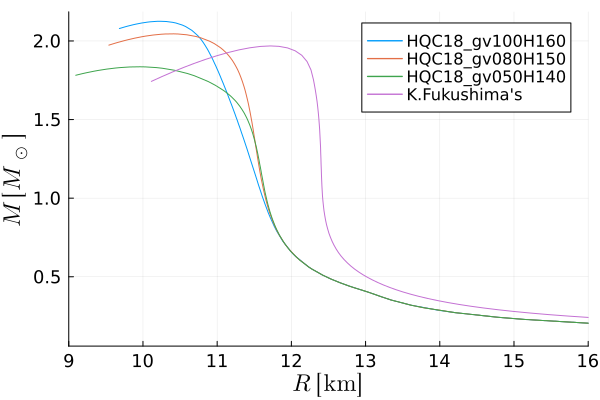

In [9]:
plot(RMT[1], RMT[2]; 
    label=replace(splitext(basename(file_path))[1], "eos_"=>""),
    legend=:topright,
    xlabel=L"R\ [\mathrm{km}]", xlabelfontsize=16,
    ylabel=L"M\ [M_\odot]", ylabelfontsize=16,
    xlims=(9,16),
    xtickfontsize=12,
    ytickfontsize=12,
)
plot!(RMT2[1], RMT2[2]; label=replace(splitext(basename(file_path2))[1], "eos_"=>""))
plot!(RMT3[1], RMT3[2]; label=replace(splitext(basename(file_path3))[1], "eos_"=>""))
plot!(RMT4[1], RMT4[2]; label="K.Fukushima's")
# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定
# savefig("three_types_QHC18_Poly_MR.pdf")  # PDFファイルとして保存

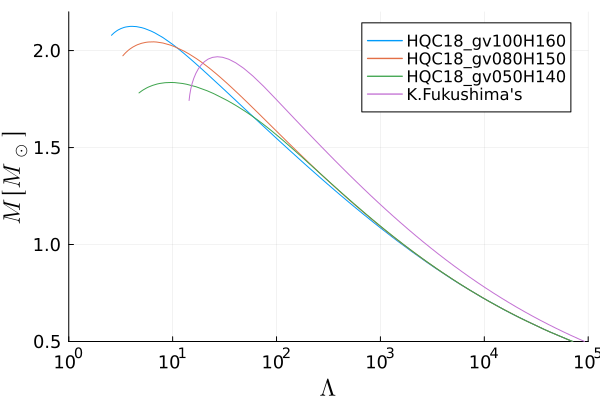

In [10]:
plot(RMT[3], RMT[2]; 
    label=replace(splitext(basename(file_path))[1], "eos_"=>""),
    legend=:topright,
    xscale=:log10,
    xlabel=L"\Lambda", xlabelfontsize=16,
    ylabel=L"M\ [M_\odot]", ylabelfontsize=16,
    xlims=(1,1e5),
    ylims=(0.5, 2.2),
    xtickfontsize=12,
    ytickfontsize=12,
)
plot!(RMT2[3], RMT2[2]; label=replace(splitext(basename(file_path2))[1], "eos_"=>""))
plot!(RMT3[3], RMT3[2]; label=replace(splitext(basename(file_path3))[1], "eos_"=>""))
plot!(RMT4[3], RMT4[2]; label="K.Fukushima's")
# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定
# savefig("three_types_QHC18_Poly_MT.pdf")  # PDFファイルとして保存

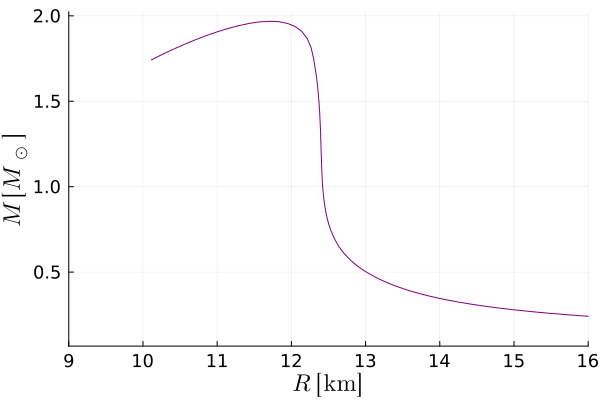

In [31]:
plot(RMT4[1], RMT4[2];
    label=nothing,
    legend=:topright,
    xlabel=L"R\ [\mathrm{km}]", xlabelfontsize=16,
    ylabel=L"M\ [M_\odot]", ylabelfontsize=16,
    xlims=(9,16),
    xtickfontsize=12,
    ytickfontsize=12,
    color=:purple,
)
# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定
# savefig("KF_MR.png")  # PDFファイルとして保存

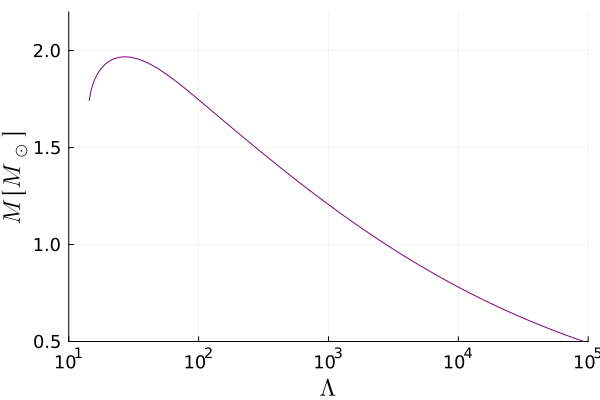

In [32]:
plot(RMT4[3], RMT4[2]; 
    legend=:topright,
    label=nothing,
    xscale=:log10,
    xlabel=L"\Lambda", xlabelfontsize=16,
    ylabel=L"M\ [M_\odot]", ylabelfontsize=16,
    xlims=(10,1e5),
    ylims=(0.5, 2.2),
    xtickfontsize=12,
    ytickfontsize=12,
    color=:purple,
)

# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定
# savefig("KF_MT.png")  # PDFファイルとして保存